In [26]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, "/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
import lifelines

from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from scipy.stats import pearsonr, spearmanr, mannwhitneyu

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

In [27]:
### STATS ###
import statsmodels.stats.multitest as multi
from matplotlib.collections import PatchCollection

In [28]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Get survival information

In [29]:
def make_df(surv,surv_type,raw):
    #get survival dataframe
    surv=pd.read_csv(surv,index_col=0)
    surv=surv.rename(columns={"bcr_patient_barcode":"FID"})
    #get genotypes
    snps=pd.read_csv(raw,delimiter=" ")
    cols=[x for x in snps.columns if x not in ["IID","PAT","MAT","SEX","PHENOTYPE"]]
    snps=snps[cols]
    #combine dataframes
    full_surv=pd.merge(surv[["FID",surv_type,surv_type+".time","age_at_initial_pathologic_diagnosis","race","gender","ajcc_pathologic_tumor_stage"]],snps,on="FID")
    #full_surv=full_surv[full_surv[surv_type+".time"]<1825] #censor at 5 years
    print(full_surv.shape)
    return(full_surv)

In [30]:
os_surv=make_df("/cellar/users/mpagadal/Data/resources/from-labmembers/andrea/Liu2018.TCGA_survival.csv","OS","/nrnb/users/mpagadal/tcga-genotypes/germline-immune/hla.snp.raw")

(8183, 112)


## Get cancer mapping

In [31]:
# map to cancer type
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
os_surv["cancer"]=os_surv["FID"].map(mp)

## Get stage information

In [32]:
#get patients with Stage designations
comb_surv_pheno=os_surv[os_surv["ajcc_pathologic_tumor_stage"].str.contains("Stage")]
comb_surv_pheno=comb_surv_pheno[~(comb_surv_pheno["ajcc_pathologic_tumor_stage"].isin(["Stage X"]))]

#split A,B,C from stage designations
comb_surv_pheno["ajcc_pathologic_tumor_stage"]=comb_surv_pheno["ajcc_pathologic_tumor_stage"].str.split("A").str[0]
comb_surv_pheno["ajcc_pathologic_tumor_stage"]=comb_surv_pheno["ajcc_pathologic_tumor_stage"].str.split("B").str[0]
comb_surv_pheno["ajcc_pathologic_tumor_stage"]=comb_surv_pheno["ajcc_pathologic_tumor_stage"].str.split("C").str[0]

comb_surv_pheno=comb_surv_pheno.join(pd.get_dummies(comb_surv_pheno["ajcc_pathologic_tumor_stage"]))

In [33]:
comb_surv_pheno['ajcc_pathologic_tumor_stage'] = comb_surv_pheno['ajcc_pathologic_tumor_stage'].replace({'Stage 0':0,'Stage I': 1,'Stage II': 2,'Stage III': 3,'Stage IV': 4})

## Get HLA-A combinations

In [34]:
comb_surv_pheno["6:29933439:T:C_T"]=comb_surv_pheno["6:29933439:T:C_C"].map({2:0,1:1,0:2})

In [35]:
combo=[]

for i,row in comb_surv_pheno.iterrows():
    if (row["6:29933439:T:C_T"]>0) & (row["6:29910358:G:C_C"]>0):
        combo.append(2)
    elif row["6:29933439:T:C_T"]>0:
        combo.append(1)
    elif row["6:29910358:G:C_C"]>0:
        combo.append(1)
    else:
        combo.append(0)
        
comb_surv_pheno["combo"]=combo 

## Get sex mapping

In [36]:
comb_surv_pheno["gender"]= comb_surv_pheno['gender'].replace({'MALE': 0,'FEMALE':1})

In [38]:
comb_surv_pheno["ajcc_pathologic_tumor_stage"].value_counts()

2    1652
1    1543
3    1346
4     663
0       6
Name: ajcc_pathologic_tumor_stage, dtype: int64

In [44]:
comb_surv_pheno=comb_surv_pheno[~comb_surv_pheno["age_at_initial_pathologic_diagnosis"].isnull()]
comb_surv_pheno=comb_surv_pheno[~comb_surv_pheno["OS"].isnull()]
comb_surv_pheno=comb_surv_pheno[~comb_surv_pheno["OS.time"].isnull()]

In [56]:
cancers=[x for x in comb_surv_pheno["cancer"].unique().tolist() if x!="TGCT"]

In [57]:
disease_df = pd.DataFrame()

for disease in cancers:
    print(disease)
    #if disease in ["BRCA","TGCT","PRAD","OV"]:
    if disease in ["x"]:
        temp_df = comb_surv_pheno[comb_surv_pheno['cancer']==disease]
        temp_df = temp_df[['age_at_initial_pathologic_diagnosis','ajcc_pathologic_tumor_stage','combo','OS','OS.time']]
        cph = CoxPHFitter()
        cph.fit(temp_df, event_col='OS', duration_col='OS.time')
        cph.summary["cancer"]=disease
        disease_df = disease_df.append(cph.summary.loc[["combo"]])
        
    else:
        temp_df = comb_surv_pheno[comb_surv_pheno['cancer']==disease]
        temp_df = temp_df[['age_at_initial_pathologic_diagnosis','gender','ajcc_pathologic_tumor_stage','combo','OS','OS.time']]
        cph = CoxPHFitter()
        cph.fit(temp_df, event_col='OS', duration_col='OS.time')
        cph.summary["cancer"]=disease
        disease_df = disease_df.append(cph.summary.loc[["combo"]])

disease_df["cancer"]=cancers


ACC
BLCA
BRCA
CHOL
COAD
ESCA
HNSC
KICH
KIRC
KIRP
LIHC
LUAD
LUSC
MESO
PAAD
READ
SKCM
STAD
THCA
UVM


In [58]:
disease_df["neg"]=disease_df["exp(coef)"]-disease_df["exp(coef) lower 95%"]
disease_df["pos"]=disease_df["exp(coef) upper 95%"]-disease_df["exp(coef)"]

In [51]:
disease_df=disease_df[disease_df["cancer"]!="TGCT"]

In [59]:
disease_df=disease_df.sort_values(by="exp(coef)")

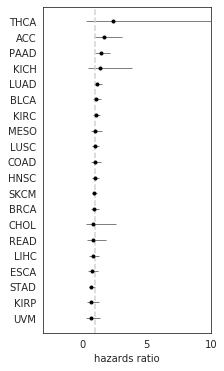

In [61]:
fig, ax = plt.subplots(figsize=(3, 6))
plt.errorbar(disease_df["exp(coef)"].tolist(),disease_df["cancer"].tolist(),xerr=disease_df[["neg","pos"]].T.values, fmt='.', color='black',
             ecolor='gray', elinewidth=1);
plt.axvline(1,linestyle="--",color="lightgray")
plt.xlabel("hazards ratio")
plt.xlim([-3,10])
plt.savefig("../plots/hazards.ratio.pdf")

In [65]:
disease_df["cancer"].tolist()

['UVM',
 'KIRP',
 'STAD',
 'ESCA',
 'LIHC',
 'READ',
 'CHOL',
 'BRCA',
 'SKCM',
 'HNSC',
 'COAD',
 'LUSC',
 'MESO',
 'KIRC',
 'BLCA',
 'LUAD',
 'KICH',
 'PAAD',
 'ACC',
 'THCA']